In [1]:
!pip install fpdf
from fpdf import FPDF
from PIL import Image
import pandas as pd
import numpy as np
import h5py
from google.colab.patches import cv2_imshow
import copy
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40722 sha256=583a1b0ca818de6cb78cbbc8ad9edbe80df1197318dfc170b33302543de3086a
  Stored in directory: /root/.cache/pip/wheels/d7/ca/c8/86467e7957bbbcbdf4cf4870fc7dc95e9a16404b2e3c3a98c3
Successfully built fpdf


In [2]:
# Process Steps
df1 = pd.read_csv(r'/content/drive/MyDrive/Heart_tissue/Output_steps_0707.csv', header=None)
df2 = pd.read_csv(r'/content/drive/MyDrive/Heart_tissue/Output_steps_1207.csv', header=None)
df3 = pd.read_csv(r'/content/drive/MyDrive/Heart_tissue/Output_steps_1307.csv', header=None)

steps1 = np.array(df1)
steps2 = np.array(df2)
steps3 = np.array(df3)

steps = np.concatenate((steps1, steps2, steps3), axis = 1)
steps = np.swapaxes(steps, 0, 1)
print(steps.shape)
print(steps.max(), steps.min())

(44, 200)
1800 -1680


In [3]:
# Process image
f1 = h5py.File('/content/drive/MyDrive/Heart_tissue/Dataset.mat','r')
f2 = h5py.File('/content/drive/MyDrive/Heart_tissue/Dataset2.mat','r')
f3 = h5py.File('/content/drive/MyDrive/Heart_tissue/Dataset3.mat','r')
# print(f1.keys())

# For converting to a NumPy array
data1 = np.array(f1.get('Output_Videos')) 
data2 = np.array(f2.get('Output_Videos'))
data3 = np.array(f3.get('Output_Videos'))

video = np.concatenate((data1, data2, data3))
video = np.swapaxes(video, 2, 3)
print(video.shape)

(44, 200, 274, 384)


In [4]:
print(video.min(), video.max())

-5375.0 8191.0


In [5]:
del data1, data2, data3

In [6]:
# Normalization
video_nor = np.zeros(video.shape)
for i, v in enumerate(video):
  v[v < -400] = -400
  video_nor[i] = (v - v.min()) / (v.max() - v.min())*255

In [7]:
print(video_nor.shape, steps.shape)

(44, 200, 274, 384) (44, 200)


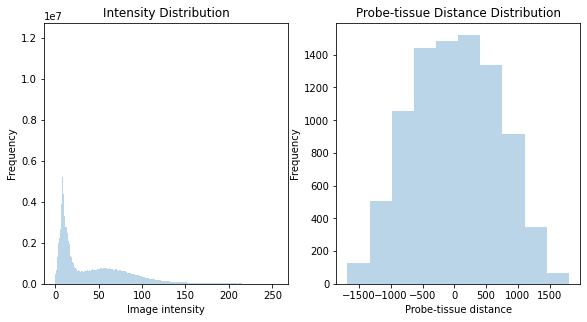

In [ ]:
plt.figure(figsize=(6.4*1.5, 4.8), constrained_layout=False)

plt.subplot(121), plt.hist(video_nor.reshape(-1), bins = 'auto', alpha=0.3), plt.title('Intensity Distribution'), plt.xlabel('Image intensity'), plt.ylabel('Frequency')
plt.subplot(122), plt.hist(steps.reshape(-1), alpha=0.3),plt.title('Probe-tissue Distance Distribution'), plt.xlabel('Probe-tissue distance'), plt.ylabel('Frequency')

# plt.savefig("intensity.png", dpi=600)
plt.show()

In [ ]:
# Dataclip (remove data above 1000 ans under -1000)
def data_clip(X_nor,Y_org):
  X_temp = np.zeros((X_nor.shape),dtype=np.float16)
  Y_temp = np.zeros((Y_org.shape),dtype=np.float16)
  acc = 0
  X_clip = []
  Y_clip = []

  for i, group in enumerate(Y_org):
    for j, dis in enumerate(group):
      if(dis <= 1000 and dis >= -1000):
        X_temp[i][acc] = X_nor[i][j]
        Y_temp[i][acc] = Y_org[i][j]
        acc += 1
    X_clip.append(X_temp[i,0:acc,:,:])
    Y_clip.append(Y_temp[i,0:acc])
    acc = 0
  X_clipped = np.array(X_clip)
  Y_clipped = np.array(Y_clip)
  return X_clipped, Y_clipped
X_clipped, Y_clipped = data_clip(video_nor, steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [19]:
cd ..

/content


In [22]:
# Save pdf  -- images against differernt distances
pdf = FPDF()
pdf.set_font('Arial', 'B', 8)
# imagelist is the list with all image filenames
x = 0
y = 1
w = 42 #68.5
h = 32 #96
i = 40
pdf.add_page()
pagename = "image : " +str(i)
pdf.text(95, 2.5, pagename)
acc = 0  
for step in np.linspace(-500, 500, num=101, endpoint=True):
  acc += 1
  idx = np.where(steps[i] == step)
  img = video_nor[i][idx]
  if img.shape[0] == 0:
    print("true")
    img = 255 * np.ones((1, 274, 384))
  image = Image.fromarray(np.uint8(img.squeeze()))
  img_name = '/content/drive/MyDrive/Heart_tissue/video_'+ str(i)+ '_step_'+str(step) + '.jpg'
  image.save(img_name)
  im = img_name
  pdf.image(im, x + (acc - 1) % 5 * w + 1.6, y + int((acc - 1) / 5) * h+3, 38.4, 27.4)
  video_name = "distance:"+str(step)
  pdf.text(x + (acc - 1) % 5 * w + 12.7, y + int((acc - 1) / 5) * h + 33, video_name)
  if acc == 45:
    acc = 0
    pdf.add_page()
    x = 0
    y = 1
pdf.output("images against differernt distances.pdf", "F")

''

In [ ]:
cd ..

/content


In [ ]:
cd /content/drive/MyDrive/Heart_tissue

/content/drive/MyDrive/Heart_tissue


In [15]:
!rm -rf *jpg

In [ ]:
y_label = copy.deepcopy(Y_clipped)
num_classes = [0, 0, 0]
# y_label = np.zeros(Y_clipped.shape)
for i,group in enumerate(Y_clipped):
  for j,dis in enumerate(group):
    if dis >= -50 and dis <= 50:
      y_label[i][j] = 0
      num_classes[0] += 1
    elif dis > 50:
      y_label[i][j] = 1
      num_classes[1] += 1
    else:
      y_label[i][j] = 2
      num_classes[2] += 1
print(num_classes)

[467, 3564, 3557]


Few-shot-learning

In [ ]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_clipped, y_label, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
# few-shot learning dataset
X_train, X_train_query, y_train, y_train_query = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
X_val, X_val_query, y_val, y_val_query = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
X_test, X_test_query, y_test, y_test_query = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
print(X_train.shape, X_train_query.shape)
print(X_val.shape, X_val_query.shape)
print(X_test.shape, X_test_query.shape)

(13,) (13,)
(4,) (5,)
(4,) (5,)


In [ ]:
def data_processing(Data):
    for i,data in enumerate(Data):
        if i == 0:
            x = data
        else:
            x = np.concatenate((x, data), axis = 0)
    return x
X_train = np.uint8(data_processing(X_train))
X_train_query = np.uint8(data_processing(X_train_query))
X_val = np.uint8(data_processing(X_val))
X_val_query = np.uint8(data_processing(X_val_query))
X_test = np.uint8(data_processing(X_test))
X_test_query = np.uint8(data_processing(X_test_query))
y_train = np.float32(data_processing(y_train))
y_train_query = np.float32(data_processing(y_train_query))
y_val = np.float32(data_processing(y_val))
y_val_query = np.float32(data_processing(y_val_query))
y_test = np.float32(data_processing(y_test))
y_test_query = np.float32(data_processing(y_test_query))

In [ ]:
image_no = 1
csv = ['train.csv','train_query.csv','val.csv','val_query.csv','test.csv','test_query.csv']
ls = [(X_train, y_train), (X_train_query, y_train_query), (X_val, y_val), 
      (X_val_query, y_val_query), (X_test,y_test),(X_test_query, y_test_query)]

path = '/content/images/'
if not os.path.exists(path):
  os.makedirs(path)

for id,(x, y) in enumerate(ls):
    df = pd.DataFrame(columns=['filename', 'label'])
    for i,image in enumerate(x):
        image = Image.fromarray(image.squeeze())
        name = 'images/' + str(image_no) + '.jpg'
        image.save(name, 'JPEG')
        df.loc[i] = [name] + [y[i]]
        image_no += 1
    path = r'/content/'
    df.to_csv(os.path.join(path,csv[id]), index = False)

In [ ]:
df = pd.DataFrame(columns=['filename', 'label'])
base = '/content'
# image_no = 1
for i,image in enumerate(X_test_query):
    image = Image.fromarray(image.squeeze())
    name = 'images/' + str(image_no) + '.jpg'
    image.save(os.path.join(base, name), 'JPEG')
    df.loc[i] = [name] + [y_test_query[i]]
    image_no += 1
df.to_csv(r'/content/test_query.csv', index = False)

In [ ]:
!zip -r heart_few_shot_data_42.zip /content/heart_few_shot_data_42

Few-shot learning train and val

In [ ]:
# split the dataset
X_train, X_val, y_train, y_val = train_test_split(X_clipped, y_label, test_size=0.2, random_state=1)

In [ ]:
# few-shot learning dataset
X_train, X_train_query, y_train, y_train_query = train_test_split(X_train, y_train, test_size=0.5, random_state=1)
X_val, X_val_query, y_val, y_val_query = train_test_split(X_val, y_val, test_size=0.5, random_state=1)

In [ ]:
print(X_train.shape, X_train_query.shape)
print(X_val.shape, X_val_query.shape)

(17,) (18,)
(4,) (5,)


In [ ]:
X_train = np.uint8(data_processing(X_train))
X_train_query = np.uint8(data_processing(X_train_query))
X_val = np.uint8(data_processing(X_val))
X_val_query = np.uint8(data_processing(X_val_query))
y_train = np.float32(data_processing(y_train))
y_train_query = np.float32(data_processing(y_train_query))
y_val = np.float32(data_processing(y_val))
y_val_query = np.float32(data_processing(y_val_query))


In [ ]:
image_no = 1
csv = ['train.csv','train_query.csv','val.csv','val_query.csv']
ls = [(X_train, y_train), (X_train_query, y_train_query), (X_val, y_val), 
      (X_val_query, y_val_query)]

path = '/content/images/'
if not os.path.exists(path):
  os.makedirs(path)

for id,(x, y) in enumerate(ls):
    df = pd.DataFrame(columns=['filename', 'label'])
    for i,image in enumerate(x):
        image = Image.fromarray(image.squeeze())
        name = 'images/' + str(image_no) + '.jpg'
        image.save(name, 'JPEG')
        df.loc[i] = [name] + [y[i]]
        image_no += 1
    path = r'/content/'
    df.to_csv(os.path.join(path,csv[id]), index = False)

In [ ]:
!zip -r heart_few_shot_train_val.zip heart_few_shot_train_val

Regular classification for pretrain

In [ ]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_clipped, y_label, test_size=0.1, random_state=1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(39,)
(5,)


In [ ]:
def data_processing(Data):
    for i,data in enumerate(Data):
        if i == 0:
            x = data
        else:
            x = np.concatenate((x, data), axis = 0)
    return x
X_train = np.uint8(data_processing(X_train))
X_test = np.uint8(data_processing(X_test))

y_train = np.float32(data_processing(y_train))
y_test = np.float32(data_processing(y_test))

In [ ]:
image_no = 1
csv = ['train.csv','test.csv']
ls = [(X_train, y_train),(X_test,y_test)]

path = '/content/images/'
if not os.path.exists(path):
  os.makedirs(path)

for id,(x, y) in enumerate(ls):
    df = pd.DataFrame(columns=['filename', 'label'])
    for i,image in enumerate(x):
        image = Image.fromarray(image.squeeze())
        name = 'images/' + str(image_no) + '.jpg'
        image.save(name, 'JPEG')
        df.loc[i] = [name] + [y[i]]
        image_no += 1
    path = r'/content/'
    df.to_csv(os.path.join(path,csv[id]), index = False)

In [ ]:
cd /content/drive/MyDrive/Heart_tissue

/content/drive/MyDrive/Heart_tissue


In [ ]:
!rm -rf *jpg

In [ ]:
!zip -r heart_pretrain.zip /content/heart_pretrain

In [ ]:
classes = ("0","1","2")
class_num = {classname:0 for classname in classes}
for data in y_train:
  class_num[classes[data.astype(np.int)]] += 1
print(class_num)

{'0': 412, '1': 3134, '2': 3155}


In [ ]:
classes = ("0","1","2")
class_num = {classname:0 for classname in classes}
for data in y_test:
  class_num[classes[data.astype(np.int)]] += 1
print(class_num)

{'0': 55, '1': 430, '2': 402}
